# Implementation of a VQ-VAE based on Jukebox by OpenAI

## Imports

In [2]:
try: 
    import librosa
except:
    !pip install librosa
try: 
    import optuna, plotly
except:
    !pip install optuna
    !pip install plotly


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn.functional as F
import optuna, plotly
from optuna.importance import get_param_importances
from optuna.visualization import plot_param_importances

# Utils
import numpy as np
from numpy import ndarray
import logging, math


# Base Scripts
from Libraries.Utils import *
from Libraries.VQ_VAE import *

## Setup

### Initial Setup

In [3]:
remote_kernel: bool = True
device: str = "cuda" if torch.cuda.is_available() else "cpu"
training_data_name: str = "../Data/training_v2_full"
test_data_name: str = "../Data/unseen_test_data.npy"
model_name: str = "VQ_VAE_v2"
full_model_path: str = OS().path_to_remote_path("../Models/{}".format(model_name), remote_kernel)

### Logging

In [4]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Data Hyperparameters

In [5]:
n_train_samples: int = 2048
batch_size: int = 24
n_workers: int = 1

### Data loading

In [5]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(training_data_name, remote_kernel))
md.create_validation_split(n_train_samples)
train_datatset, val_dataset = md.create_datasets()
train_dataloader, val_dataloader = md.create_dataloaders(batch_size, num_workers=n_workers)
logger.info(f"Created train dataset with length {len(md.train_dataset)} and validation dataset with length {len(md.val_dataset)}")

2025-07-17 12:30:15,631 - INFO - Created train dataset with length 2048 and validation dataset with length 102


In [6]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(test_data_name, remote_kernel))
md.create_validation_split()
test_dataset, _ = md.create_datasets()
test_dataloader, _ = md.create_dataloaders(batch_size, num_workers=n_workers)
logger.info(f"Created test dataset with length {len(md.train_dataset)}")

2025-07-17 14:03:04,422 - INFO - Created test dataset with length 268


## Model Setup

### Hyperparameters

In [9]:
b1, b2 = (0.9, 0.99)
lr: float = 5e-5
n_epochs: int = 210
checkpoint_freq: int = 5
lr_restart_period: int = 50
restart_training: bool = True

### Models

In [10]:
vq_vae = VQVAE(input_emb_width=1, output_emb_width=64, k_bins=2048, levels=1, downs_t=[3], strides_t=[2]).to(device)

### Optimizers & Schedulers

In [11]:
optimizer = optim.AdamW(vq_vae.parameters(), lr, (b1, b2))
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=lr_restart_period, eta_min=1e-7, T_mult=2)

### Load Model

In [12]:
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    vq_vae.load_state_dict(model["vq_vae"])

    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(vq_vae)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(vq_vae)} Parameters")

2025-07-17 14:03:18,209 - INFO - Model VQ_VAE_v2 loaded with ~597.5k Parameters


## Training

In [16]:
torch.backends.cudnn.benchmark = True
loss_fn = nn.MSELoss()
commit_loss_weight = 0.02

In [17]:
logger.info(f"Training started on {device}")
loss_list: list = []
total_time: float = 0.0

for e in range(n_epochs):
    total_loss: float = 0
    start_time: float = time.time()

    for b_idx, (audio, _) in enumerate(train_dataloader):
        audio: Tensor = audio.to(device)
        if audio.ndim == 2:
            audio = audio.unsqueeze(1)
        with torch.autocast(device):
            x_recon, z_q, commit_loss, metrics = vq_vae(audio)
            recon_loss = loss_fn(x_recon, audio)
            loss = recon_loss + commit_loss_weight *commit_loss
        if loss.item() == torch.nan:
            break
        fit = metrics["fit"]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss
    else:
        epoch_time = time.time() - start_time
        total_time += epoch_time
        remaining_time = int((total_time / (e + 1)) * (n_epochs - e - 1))
        avg_loss = total_loss / len(train_dataloader)

        scheduler.step()

        logger.info(f"Epoch {e + 1:03d}: Avg. Loss: {avg_loss:.4e} Fit {fit.item():.4e} Remaining Time: {remaining_time // 3600:02d}h {(remaining_time % 3600) // 60:02d}min {round(remaining_time % 60):02d}s LR: {optimizer.param_groups[0]['lr']:.5e}")

        if checkpoint_freq > 0 and (e + 1) % checkpoint_freq == 0:
                checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1:03d}.pth"
                torch.save({"vq_vae": vq_vae.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, checkpoint_path)
                if e + 1 != checkpoint_freq:
                    last_path: str = f"{full_model_path[:-4]}_epoch_{(e + 1) - checkpoint_freq:03d}.pth"
                    OS().del_if_exists(last_path)
                logger.light_debug(f"Checkpoint saved model to {checkpoint_path}")
        continue
    break


torch.save({"vq_vae": vq_vae.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, full_model_path)
logger.light_debug(f"Saved model to {full_model_path}")

if checkpoint_freq > 0:
    checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1 - ((e + 1) % checkpoint_freq):03d}.pth"
    OS().del_if_exists(checkpoint_path)


2025-07-17 10:30:41,672 - INFO - Training started on cuda


KeyboardInterrupt: 

torch.Size([24, 1, 262144])
tensor([[ 883,  530,  514,  ...,  697, 1706, 1862],
        [ 883, 1711, 2021,  ...,  655,  716, 1520],
        [ 690, 1123,  841,  ..., 1123, 1123,  881],
        ...,
        [ 883, 1388,  473,  ..., 1959, 1933,  886],
        [ 912,   48,  630,  ..., 1469,  516, 1151],
        [ 764,  730, 1879,  ...,  232, 1906,  924]], device='cuda:0') {'fit': tensor(0.8944, device='cuda:0'), 'pn': tensor(0.8192, device='cuda:0')}
(262144,)


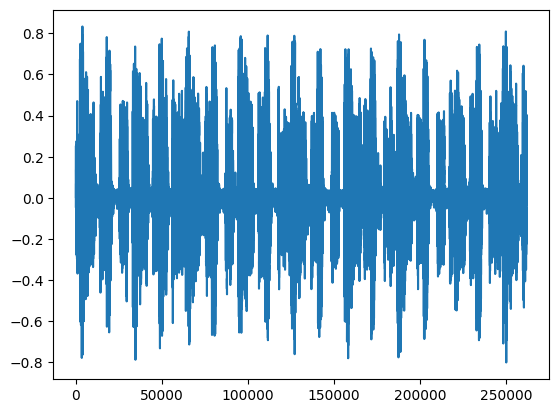

In [20]:
vq_vae.eval()
inp = next(iter(val_dataloader))[0].unsqueeze(1).to(device)
print(inp.shape)
with torch.no_grad():
    output, q_z, commit_loss, metrics = vq_vae(inp)
print(q_z, metrics)
vq_vae.train()
print(output[1][0].cpu().numpy().shape)
AudioData(output[1][0].cpu().numpy()).save_audio_file("Results/VQVAE2_Test1.wav")
plt.plot(output[1][0].cpu().numpy())
plt.show()

In [10]:
def generate_latent_repr(vq_vae: nn.Module, data: Dataset, batch_size: int = 24, device: str = "cpu") -> Dataset:
    data_loader = DataLoader(data, batch_size=batch_size)
    converted_data = []
    vq_vae.eval()
    for b,_ in (data_loader):
        _, q_z, _, _ = vq_vae(b.unsqueeze(1).to(device))
        converted_data.append(q_z)
    vq_vae.train()
    new_data = torch.cat(converted_data, dim=0)
    return AudioDataset(new_data, data_type=torch.long)

In [12]:
transposed_ds = generate_latent_repr(vq_vae, test_dataset, 24, device)
transposed_dl = DataLoader(transposed_ds, batch_size, shuffle=False)

In [17]:
idx = 16
inp = next(iter(transposed_dl))[0].to(device)
inp_true = next(iter(test_dataloader))[0].unsqueeze(1).to(device)
print(inp.shape)
vq_vae.eval()
with torch.no_grad():
    outp = vq_vae.decode(inp)
AudioData(inp_true[idx][0].cpu().numpy()).save_audio_file("Results/VQVAE2_true_{}.wav".format(idx))
AudioData(outp[idx][0].cpu().numpy()).save_audio_file("Results/VQVAE2_split_{}.wav".format(idx))

torch.Size([24, 32768])


torch.Size([24, 1, 262144])
torch.Size([24, 32768])
L1 Error True-Out: 1.889e+04 Out-Split Out:9.992e+03


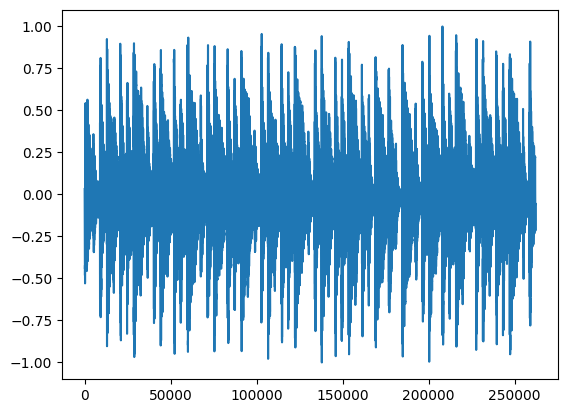

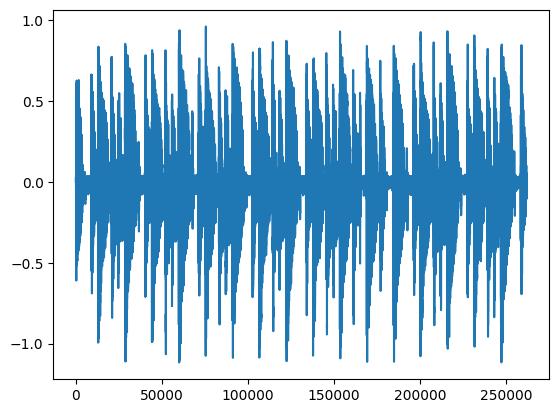

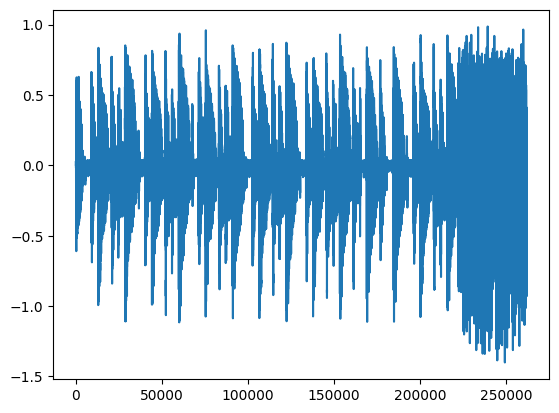

In [18]:
idx = 0
n = 5000
vq_vae.eval()
inp = next(iter(test_dataloader))[0].unsqueeze(1).to(device)#next(iter(val_dataloader))[0].unsqueeze(1).to(device)
print(inp.shape)
with torch.no_grad():
    output, q_z, commit_loss, metrics = vq_vae(inp)
    q_z[idx, -n:] = torch.randint(low=0, high=2048, size=(n,))
    print(q_z.shape)
    outp = vq_vae.decode(q_z)

print(f"L1 Error True-Out: {np.sum(np.abs(inp[idx][0].cpu().numpy() - output[idx][0].cpu().numpy())):.3e} Out-Split Out:{np.sum(np.abs(outp[idx][0].cpu().numpy() - output[idx][0].cpu().numpy())):.3e}")
#AudioData(inp[idx][0].cpu().numpy()).save_audio_file("Results/VQVAE2_Test_inp_{}.wav".format(idx))
#AudioData(output[idx][0].cpu().numpy()).save_audio_file("Results/VQVAE2_Test_out_{}.wav".format(idx))
#AudioData(outp[idx][0].cpu().numpy()).save_audio_file("Results/VQVAE2_Test_out_split_{}.wav".format(idx))
plt.plot(inp[idx][0].cpu().numpy())
plt.show()
plt.plot(output[idx][0].cpu().numpy())
plt.show()
plt.plot(outp[idx][0].cpu().numpy())
plt.show()